### Project Discription:

#### **Dataset**: https://github.com/ant-research/EasyTemporalPointProcess
#### **Model Method**: https://arxiv.org/abs/1705.08982

### Install EasyTPP and Data Loading

In [ ]:
!pip install git+https://github.com/ant-research/EasyTemporalPointProcess.git

  Cloning https://github.com/ant-research/EasyTemporalPointProcess.git to /tmp/pip-req-build-ay3k915g
  Running command git clone --filter=blob:none --quiet https://github.com/ant-research/EasyTemporalPointProcess.git /tmp/pip-req-build-ay3k915g
  Resolved https://github.com/ant-research/EasyTemporalPointProcess.git to commit e27440645e2278a6d20aa0d0bdec3ee53aaf91d5
  Preparing metadata (setup.py) ... done


In [ ]:
from datasets import load_dataset

# we choose taxi dataset as it is relatively small
dataset = load_dataset('easytpp/taxi')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

train.json:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

dev.json:   0%|          | 0.00/327k [00:00<?, ?B/s]

test.json:   0%|          | 0.00/654k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1400 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['seq_len', 'time_since_start', 'seq_idx', 'time_since_last_event', 'type_event', 'dim_process'],
        num_rows: 1400
    })
    validation: Dataset({
        features: ['seq_len', 'time_since_start', 'seq_idx', 'time_since_last_event', 'type_event', 'dim_process'],
        num_rows: 200
    })
    test: Dataset({
        features: ['seq_len', 'time_since_start', 'seq_idx', 'time_since_last_event', 'type_event', 'dim_process'],
        num_rows: 400
    })
})

In [ ]:
dataset['train']['type_event'][0]

[8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3,
 8,
 3]

In [ ]:
#As an illustrative example, we write the YAML content to a file
yaml_content = """
pipeline_config_id: data_config

data_format: json
train_dir: easytpp/taxi  # ./data/taxi/train.json
valid_dir: easytpp/taxi  # ./data/taxi/dev.json
test_dir: easytpp/taxi   # ./data/taxi/test.json
data_specs:
  num_event_types: 10
  pad_token_id: 10
  padding_side: right
"""

# Save the content to a file named config.yaml
with open("config.yaml", "w") as file:
    file.write(yaml_content)

In [ ]:
from easy_tpp.config_factory import Config
from easy_tpp.preprocess.data_loader import TPPDataLoader


config = Config.build_from_yaml_file('./config.yaml')
tpp_loader = TPPDataLoader(config)

2024-12-01 20:20:11,248 - config.py[pid:4048;line:34:build_from_yaml_file] - CRITICAL: Load pipeline config class DataConfig


## Dataset Statistics

In [ ]:
stats = tpp_loader.get_statistics(split='train')
stats

{'num_sequences': 1400,
 'avg_sequence_length': 37.03857142857143,
 'event_type_distribution': {8: 23131,
  3: 22239,
  5: 2161,
  0: 2088,
  1: 1443,
  6: 625,
  4: 107,
  2: 50,
  9: 4,
  7: 6},
 'max_sequence_length': 38,
 'min_sequence_length': 36,
 'mean_time_delta': 0.21851826495759416,
 'min_time_delta': 0.0,
 'max_time_delta': 5.721388888888889}

In [ ]:
stats_test = tpp_loader.get_statistics(split='test')
stats_test

{'num_sequences': 400,
 'avg_sequence_length': 37.05,
 'event_type_distribution': {8: 6648,
  3: 6395,
  1: 399,
  0: 562,
  5: 555,
  4: 38,
  6: 202,
  9: 2,
  7: 3,
  2: 16},
 'max_sequence_length': 38,
 'min_sequence_length': 36,
 'mean_time_delta': 0.21560524441445447,
 'min_time_delta': 0.0,
 'max_time_delta': 5.246944444444444}

### Event Type Distribution Plot

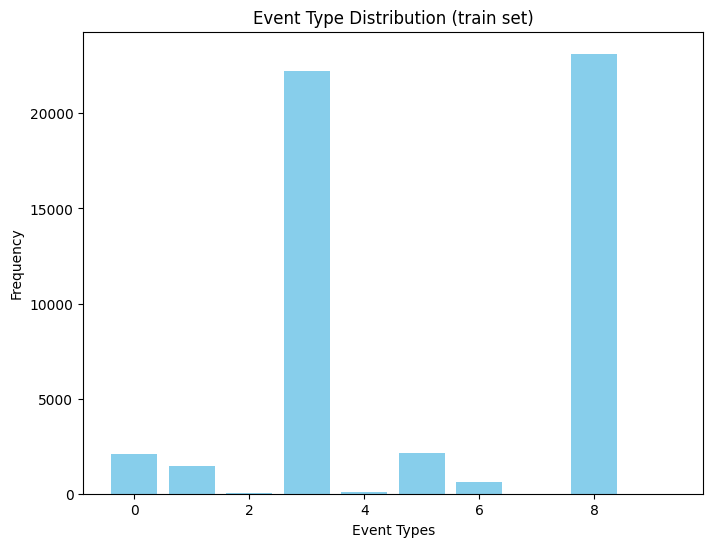

In [ ]:
tpp_loader.plot_event_type_distribution()

### Event Delta Time Distribution Plot

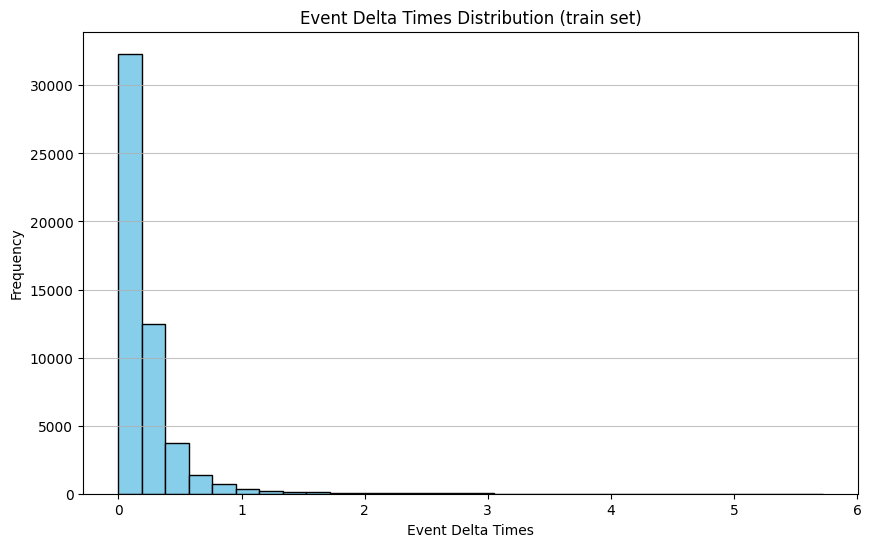

In [ ]:
tpp_loader.plot_event_delta_times_distribution()

### Model

### version 1

In [ ]:
# Convert 'time_since_last_event' to tensors and pad sequences
x_times_train_padded = pad_sequence(
    [torch.tensor(seq, dtype=torch.float32) for seq in dataset['train']['time_since_last_event']],
    batch_first=True,
    padding_value=0.0  # Padding value for time differences
).to('cpu')  # Use 'cpu' or 'cuda' depending on your device

# Convert 'type_event' to tensors and pad sequences
y_events_train_padded = pad_sequence(
    [torch.tensor(seq, dtype=torch.long) for seq in dataset['train']['type_event']],
    batch_first=True,
    padding_value=9  # Assuming event_class = 10; use (event_class - 1) for padding
).to('cpu')  # Use 'cpu' or 'cuda' depending on your device


# Create a TensorDataset and DataLoader with the loaded real dataset
train_dataset = TensorDataset(x_times_train_padded, y_events_train_padded)
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)



Training Deterministic Model
Epoch [1/10], Loss: 0.9997
Epoch [2/10], Loss: 0.5225
Epoch [3/10], Loss: 0.5100
Epoch [4/10], Loss: 0.5118
Epoch [5/10], Loss: 0.5122
Epoch [6/10], Loss: 0.5114
Epoch [7/10], Loss: 0.5169
Epoch [8/10], Loss: 0.5061
Epoch [9/10], Loss: 0.5128
Epoch [10/10], Loss: 0.5153

Training Probabilistic Model
Epoch [1/10], Loss: 1.5937
Epoch [2/10], Loss: 1.1210
Epoch [3/10], Loss: 1.1315
Epoch [4/10], Loss: 1.1159
Epoch [5/10], Loss: 1.1233
Epoch [6/10], Loss: 1.1301
Epoch [7/10], Loss: 1.1298
Epoch [8/10], Loss: 1.1347
Epoch [9/10], Loss: 1.1015
Epoch [10/10], Loss: 1.1287

Deterministic Model Predictions:
Time Predictions: [[ 0.23588645]
 [ 0.23370199]
 [ 0.23509859]
 [-0.01894591]
 [-0.01978017]
 [ 0.23788702]
 [ 0.23410775]
 [ 0.23890202]
 [-0.01903649]
 [-0.01918978]
 [ 0.00056435]
 [-0.00815637]
 [ 0.2357909 ]
 [-0.01898612]
 [ 0.24004504]
 [-0.01902844]]
Event Predictions: [3 3 3 9 9 3 3 3 9 9 9 9 3 9 3 9]

Probabilistic Model Predictions:
Time Predictions: [

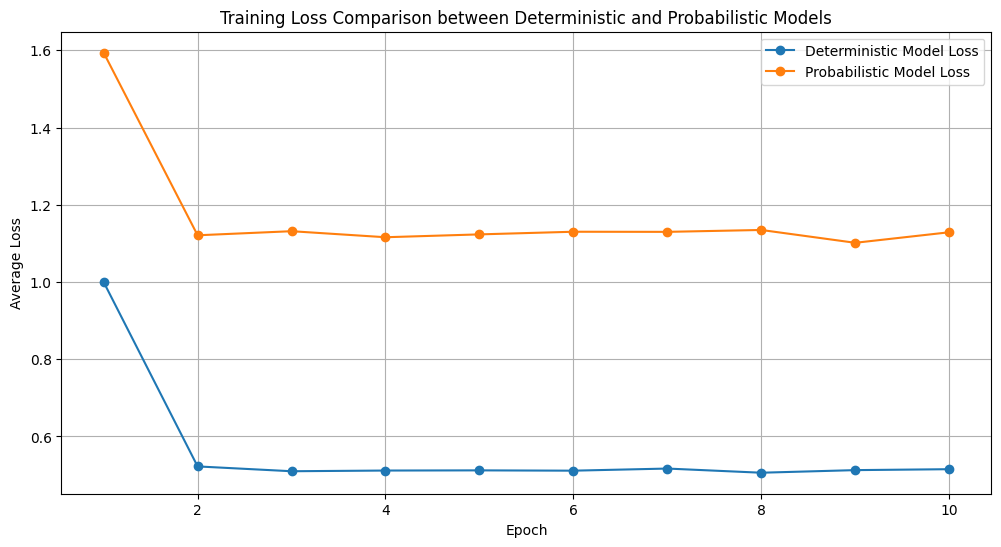

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PointProcessNet(nn.Module):
    def __init__(self, config, lossweight, probabilistic=False):
        super(PointProcessNet, self).__init__()
        self.config = config
        self.probabilistic = probabilistic
        self.n_class = config.event_class
        self.embedding = nn.Embedding(num_embeddings=config.event_class, embedding_dim=config.emb_dim)
        self.emb_drop = nn.Dropout(p=config.dropout)
        self.lstm = nn.LSTM(input_size=config.emb_dim + 1,
                            hidden_size=config.hid_dim,
                            batch_first=True,
                            bidirectional=False)
        self.mlp = nn.Linear(in_features=config.hid_dim, out_features=config.mlp_dim)
        self.mlp_drop = nn.Dropout(p=config.dropout)
        self.event_linear = nn.Linear(in_features=config.mlp_dim, out_features=config.event_class)
        self.time_linear = nn.Linear(in_features=config.mlp_dim, out_features=1)
        self.set_criterion(lossweight)

    def set_optimizer(self):
        self.optimizer = Adam(params=self.parameters(), lr=self.config.lr)
        self.scheduler = StepLR(self.optimizer, step_size=100, gamma=0.1)

    def set_criterion(self, weight):
        self.event_criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(weight).to(device))
        if self.probabilistic:
            self.intensity_w = nn.Parameter(torch.tensor(0.1, dtype=torch.float, device=device))
            self.intensity_b = nn.Parameter(torch.tensor(0.1, dtype=torch.float, device=device))
            self.time_criterion = self.probabilistic_loss
        else:
            self.time_criterion = nn.MSELoss()

    def probabilistic_loss(self, pred, gold):
        # Introducing a probabilistic approach for loss, similar to RMTPP but with stochastic components
        mean_pred = torch.mean(pred)
        variance_pred = torch.var(pred) + 1e-6  # Adding a small value to prevent zero variance
        gaussian_dist = torch.distributions.Normal(mean_pred, variance_pred.sqrt())
        log_prob = gaussian_dist.log_prob(gold)
        loss = -torch.mean(log_prob)
        return loss

    def forward(self, input_time, input_events):
        event_embedding = self.embedding(input_events)
        event_embedding = self.emb_drop(event_embedding)
        lstm_input = torch.cat((event_embedding, input_time.unsqueeze(-1)), dim=-1)
        hidden_state, _ = self.lstm(lstm_input)

        mlp_output = torch.tanh(self.mlp(hidden_state[:, -1, :]))
        mlp_output = self.mlp_drop(mlp_output)
        event_logits = self.event_linear(mlp_output)
        time_logits = self.time_linear(mlp_output)

        if self.probabilistic:
            # Apply a probabilistic component to time prediction using reparameterization trick
            time_mean = time_logits
            time_log_var = torch.log(1 + torch.exp(time_logits))
            epsilon = torch.randn_like(time_log_var)
            time_logits = time_mean + epsilon * torch.exp(0.5 * time_log_var)

        return time_logits, event_logits

    def dispatch(self, tensors):
        for i in range(len(tensors)):
            tensors[i] = tensors[i].to(device).contiguous()
        return tensors

    def train_batch(self, batch):
        self.train()
        time_tensor, event_tensor = batch
        time_input, time_target = self.dispatch([time_tensor[:, :-1], time_tensor[:, -1]])
        event_input, event_target = self.dispatch([event_tensor[:, :-1], event_tensor[:, -1]])

        self.optimizer.zero_grad()
        time_logits, event_logits = self.forward(time_input, event_input)
        loss1 = self.time_criterion(time_logits.view(-1), time_target.view(-1))
        loss2 = self.event_criterion(event_logits.view(-1, self.n_class), event_target.view(-1))
        loss = self.config.alpha * loss1 + loss2
        loss.backward()

        self.optimizer.step()
        self.scheduler.step()
        return loss1.item(), loss2.item(), loss.item()

    def predict(self, batch):
        self.eval()
        time_tensor, event_tensor = batch
        time_input, time_target = self.dispatch([time_tensor[:, :-1], time_tensor[:, -1]])
        event_input, event_target = self.dispatch([event_tensor[:, :-1], event_tensor[:, -1]])
        with torch.no_grad():
            time_logits, event_logits = self.forward(time_input, event_input)
        event_pred = np.argmax(event_logits.detach().cpu().numpy(), axis=-1)
        time_pred = time_logits.detach().cpu().numpy()
        return time_pred, event_pred

# Configuration for Taxi Dataset
class Config:
    def __init__(self):
        self.event_class = 10
        self.emb_dim = 32
        self.hid_dim = 64
        self.mlp_dim = 64
        self.dropout = 0.2
        self.lr = 0.001
        self.alpha = 0.5
        self.model = 'deterministic'

config = Config()

# Instantiate deterministic and probabilistic models
deterministic_model = PointProcessNet(config=config, lossweight=[1.0]*config.event_class, probabilistic=False).to(device)
probabilistic_model = PointProcessNet(config=config, lossweight=[1.0]*config.event_class, probabilistic=True).to(device)

# # Instantiate and train the deterministic model
# config = Config()
# deterministic_model = PointProcessNet(config=config, lossweight=[1.0]*config.event_class, probabilistic=False).to('cpu')
# probabilistic_model = PointProcessNet(config=config, lossweight=[1.0]*config.event_class, probabilistic=True).to('cpu')
# Call set_optimizer for both models
deterministic_model.set_optimizer(total_step=len(dataloader), use_bert=False) # This line was missing
probabilistic_model.set_optimizer(total_step=len(dataloader), use_bert=False)

# Load the dataset from HuggingFace
dataset = load_dataset('easytpp/taxi')

# Extract features from the train split using the correct column names
#x_times_train = torch.tensor(dataset['train']['time_since_last_event'], dtype=torch.float32).to(device)
x_times_train_padded = pad_sequence(
    [torch.tensor(seq, dtype=torch.float32) for seq in dataset['train']['time_since_last_event']],
    batch_first=True,
    padding_value=0.0  # Choose an appropriate padding value
).to(device)
#x_times_train = x_times_train_padded.unsqueeze(-1)
#y_events_train = torch.tensor(dataset['train']['type_event'], dtype=torch.long).to(device)
y_events_train_padded = pad_sequence(
    [torch.tensor(seq, dtype=torch.long) for seq in dataset['train']['type_event']],
    batch_first=True,
    padding_value=config.event_class -1
).to(device)

# Create a TensorDataset and DataLoader with the loaded real dataset
train_dataset = TensorDataset(x_times_train_padded, y_events_train_padded)
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Training Loop for Deterministic Model
deterministic_losses = []
print("Training Deterministic Model")
for epoch in range(10):
    total_loss = 0
    for batch in dataloader:
        loss1, loss2, loss = deterministic_model.train_batch(batch)
        total_loss += loss
    avg_loss = total_loss / len(dataloader)
    deterministic_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/10], Loss: {avg_loss:.4f}")

# Training Loop for Probabilistic Model
probabilistic_losses = []
print("\nTraining Probabilistic Model")
for epoch in range(10):
    total_loss = 0
    for batch in dataloader:
        loss1, loss2, loss = probabilistic_model.train_batch(batch)
        total_loss += loss
    avg_loss = total_loss / len(dataloader)
    probabilistic_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/10], Loss: {avg_loss:.4f}")

# Example prediction for both models
with torch.no_grad():
    for batch in dataloader:
        print("\nDeterministic Model Predictions:")
        time_pred, event_pred = deterministic_model.predict(batch)
        print("Time Predictions:", time_pred)
        print("Event Predictions:", event_pred)

        print("\nProbabilistic Model Predictions:")
        time_pred, event_pred = probabilistic_model.predict(batch)
        print("Time Predictions:", time_pred)
        print("Event Predictions:", event_pred)
        break  # Only show predictions for the first batch

# Data Visualization
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), deterministic_losses, label='Deterministic Model Loss', marker='o')
plt.plot(range(1, 11), probabilistic_losses, label='Probabilistic Model Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Comparison between Deterministic and Probabilistic Models')
plt.legend()
plt.grid(True)
plt.show()


### version 2 with slightly changes

Training Deterministic Model
Epoch [1/10], Loss: 1.0022
Epoch [2/10], Loss: 0.5369
Epoch [3/10], Loss: 0.5203
Epoch [4/10], Loss: 0.5196
Epoch [5/10], Loss: 0.5281
Epoch [6/10], Loss: 0.5235
Epoch [7/10], Loss: 0.5224
Epoch [8/10], Loss: 0.5201
Epoch [9/10], Loss: 0.5232
Epoch [10/10], Loss: 0.5243

Training Probabilistic Model
Epoch [1/10], Loss: 1.6400
Epoch [2/10], Loss: 1.1365
Epoch [3/10], Loss: 1.1349
Epoch [4/10], Loss: 1.1234
Epoch [5/10], Loss: 1.1313
Epoch [6/10], Loss: 1.1563
Epoch [7/10], Loss: 1.1293
Epoch [8/10], Loss: 1.1263
Epoch [9/10], Loss: 1.1268
Epoch [10/10], Loss: 1.1369

Deterministic Model Predictions:
Time Predictions: [[ 0.2406949 ]
 [ 0.24002378]
 [ 0.23682137]
 [-0.0062955 ]
 [-0.00093921]
 [ 0.23687609]
 [-0.00832928]
 [ 0.2370695 ]
 [ 0.25361001]
 [ 0.32942817]
 [ 0.25043398]
 [-0.00175234]
 [ 0.23677282]
 [ 0.2368112 ]
 [-0.00952603]
 [ 0.28035542]]
Event Predictions: [3 3 3 9 9 3 9 3 3 3 3 9 3 3 9 3]

Probabilistic Model Predictions:
Time Predictions: [

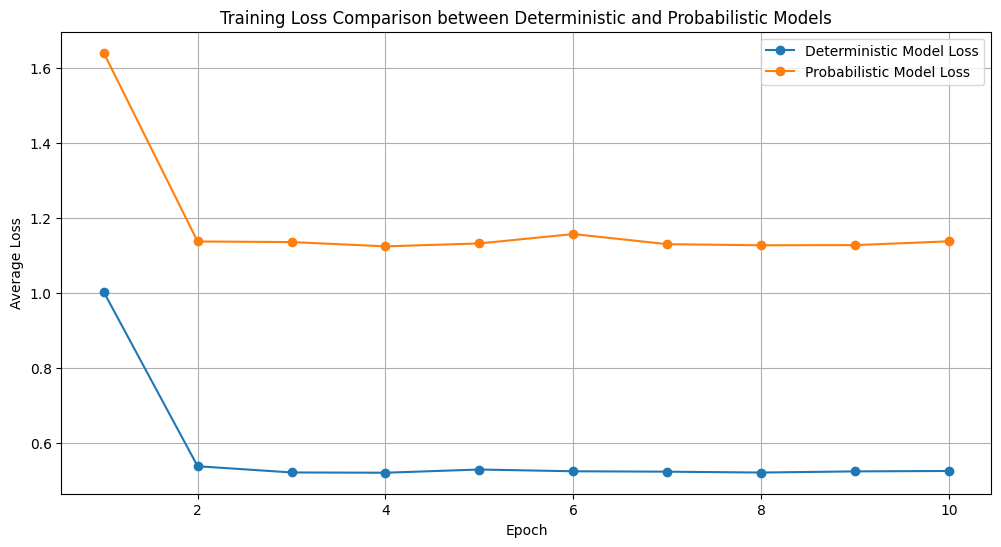

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PointProcessNet(nn.Module):
    def __init__(self, config, lossweight, probabilistic=False):
        super(PointProcessNet, self).__init__()
        self.config = config
        self.probabilistic = probabilistic
        self.n_class = config.event_class
        self.embedding = nn.Embedding(num_embeddings=config.event_class, embedding_dim=config.emb_dim)
        self.emb_drop = nn.Dropout(p=config.dropout)
        self.lstm = nn.LSTM(input_size=config.emb_dim + 1,
                            hidden_size=config.hid_dim,
                            batch_first=True,
                            bidirectional=False)
        self.mlp = nn.Linear(in_features=config.hid_dim, out_features=config.mlp_dim)
        self.mlp_drop = nn.Dropout(p=config.dropout)
        self.event_linear = nn.Linear(in_features=config.mlp_dim, out_features=config.event_class)

        # 时间间隔预测（均值和方差）
        self.fc_time_mean = nn.Linear(in_features=config.mlp_dim, out_features=1)  # 均值
        self.fc_time_logvar = nn.Linear(in_features=config.mlp_dim, out_features=1)  # 对数方差

        self.time_linear = nn.Linear(in_features=config.mlp_dim, out_features=1)
        self.set_criterion(lossweight)

    def set_optimizer(self, total_step, use_bert=True):
        self.optimizer = Adam(params=self.parameters(), lr=self.config.lr)
        self.scheduler = StepLR(self.optimizer, step_size=100, gamma=0.1)

    def set_criterion(self, weight):
        self.event_criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(weight).to(device))
        if self.probabilistic:
            self.intensity_w = nn.Parameter(torch.tensor(0.1, dtype=torch.float, device=device))
            self.intensity_b = nn.Parameter(torch.tensor(0.1, dtype=torch.float, device=device))
            self.time_criterion = self.probabilistic_loss
        else:
            self.time_criterion = nn.MSELoss()

    def probabilistic_loss(self, pred, gold):
        # Introducing a probabilistic approach for loss, similar to RMTPP but with stochastic components
        mean_pred = torch.mean(pred)
        variance_pred = torch.var(pred) + 1e-6  # Adding a small value to prevent zero variance
        gaussian_dist = torch.distributions.Normal(mean_pred, variance_pred.sqrt())
        log_prob = gaussian_dist.log_prob(gold)
        loss = -torch.mean(log_prob)
        return loss

    def forward(self, input_time, input_events):
        event_embedding = self.embedding(input_events)
        event_embedding = self.emb_drop(event_embedding)
        lstm_input = torch.cat((event_embedding, input_time.unsqueeze(-1)), dim=-1)
        hidden_state, _ = self.lstm(lstm_input)

        mlp_output = torch.tanh(self.mlp(hidden_state[:, -1, :]))
        mlp_output = self.mlp_drop(mlp_output)
        event_logits = self.event_linear(mlp_output)
        time_logits = self.time_linear(mlp_output)

        if self.probabilistic:
            # Apply a probabilistic component to time prediction using reparameterization trick
            time_mean = time_logits
            time_log_var = torch.log(1 + torch.exp(time_logits))
            epsilon = torch.randn_like(time_log_var)
            time_logits = time_mean + epsilon * torch.exp(0.5 * time_log_var)

        return time_logits, event_logits

    def dispatch(self, tensors):
        for i in range(len(tensors)):
            tensors[i] = tensors[i].to(device).contiguous()
        return tensors

    def train_batch(self, batch):
        self.train()
        time_tensor, event_tensor = batch
        time_input, time_target = self.dispatch([time_tensor[:, :-1], time_tensor[:, -1]])
        event_input, event_target = self.dispatch([event_tensor[:, :-1], event_tensor[:, -1]])

        self.optimizer.zero_grad()
        time_logits, event_logits = self.forward(time_input, event_input)
        loss1 = self.time_criterion(time_logits.view(-1), time_target.view(-1))
        loss2 = self.event_criterion(event_logits.view(-1, self.n_class), event_target.view(-1))
        loss = self.config.alpha * loss1 + loss2
        loss.backward()

        self.optimizer.step()
        self.scheduler.step()
        return loss1.item(), loss2.item(), loss.item()

    def predict(self, batch):
        self.eval()
        time_tensor, event_tensor = batch
        time_input, time_target = self.dispatch([time_tensor[:, :-1], time_tensor[:, -1]])
        event_input, event_target = self.dispatch([event_tensor[:, :-1], event_tensor[:, -1]])
        with torch.no_grad():
            time_logits, event_logits = self.forward(time_input, event_input)
        event_pred = np.argmax(event_logits.detach().cpu().numpy(), axis=-1)
        time_pred = time_logits.detach().cpu().numpy()
        return time_pred, event_pred

# Configuration for Taxi Dataset
class Config:
    def __init__(self):
        self.event_class = 10
        self.emb_dim = 32
        self.hid_dim = 64
        self.mlp_dim = 64
        self.dropout = 0.2
        self.lr = 0.001
        self.alpha = 0.5
        self.model = 'deterministic'

config = Config()

# Instantiate deterministic and probabilistic models
deterministic_model = PointProcessNet(config=config, lossweight=[1.0]*config.event_class, probabilistic=False).to(device)
probabilistic_model = PointProcessNet(config=config, lossweight=[1.0]*config.event_class, probabilistic=True).to(device)

# Call set_optimizer for both models
deterministic_model.set_optimizer(total_step=len(dataloader), use_bert=False) # This line was missing
probabilistic_model.set_optimizer(total_step=len(dataloader), use_bert=False)

# Load the dataset from HuggingFace
dataset = load_dataset('easytpp/taxi')

# Extract features from the train split using the correct column names
x_times_train_padded = pad_sequence(
    [torch.tensor(seq, dtype=torch.float32) for seq in dataset['train']['time_since_last_event']],
    batch_first=True,
    padding_value=0.0  # Choose an appropriate padding value
).to(device)
y_events_train_padded = pad_sequence(
    [torch.tensor(seq, dtype=torch.long) for seq in dataset['train']['type_event']],
    batch_first=True,
    padding_value=config.event_class - 1  # pad with the last event type index by default
).to(device)

# Create a TensorDataset and DataLoader with the loaded real dataset
train_dataset = TensorDataset(x_times_train_padded, y_events_train_padded)
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Training Loop for Deterministic Model
deterministic_losses = []
print("Training Deterministic Model")
for epoch in range(10):
    total_loss = 0
    for batch in dataloader:
        loss1, loss2, loss = deterministic_model.train_batch(batch)
        total_loss += loss
    avg_loss = total_loss / len(dataloader)
    deterministic_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/10], Loss: {avg_loss:.4f}")

# Training Loop for Probabilistic Model
probabilistic_losses = []
print("\nTraining Probabilistic Model")
for epoch in range(10):
    total_loss = 0
    for batch in dataloader:
        loss1, loss2, loss = probabilistic_model.train_batch(batch)
        total_loss += loss
    avg_loss = total_loss / len(dataloader)
    probabilistic_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/10], Loss: {avg_loss:.4f}")

# Example prediction for both models
with torch.no_grad():
    for batch in dataloader:
        print("\nDeterministic Model Predictions:")
        time_pred, event_pred = deterministic_model.predict(batch)
        print("Time Predictions:", time_pred)
        print("Event Predictions:", event_pred)

        print("\nProbabilistic Model Predictions:")
        time_pred, event_pred = probabilistic_model.predict(batch)
        print("Time Predictions:", time_pred)
        print("Event Predictions:", event_pred)
        break  # Only show predictions for the first batch

# Data Visualization
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), deterministic_losses, label='Deterministic Model Loss', marker='o')
plt.plot(range(1, 11), probabilistic_losses, label='Probabilistic Model Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Comparison between Deterministic and Probabilistic Models')
plt.legend()
plt.grid(True)
plt.show()


## Added in: Contrasting Deterministic and Probabilistic Models

In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Load the Taxi dataset from Hugging Face
dataset = load_dataset('easytpp/taxi')

# Convert 'time_since_last_event' to tensors and pad sequences
x_times_train_padded = pad_sequence(
    [torch.tensor(seq, dtype=torch.float32) for seq in dataset['train']['time_since_last_event']],
    batch_first=True,
    padding_value=0.0  # Padding value for time differences
).to('cpu')  # Use 'cpu' or 'cuda' depending on your device

# Convert 'type_event' to tensors and pad sequences
y_events_train_padded = pad_sequence(
    [torch.tensor(seq, dtype=torch.long) for seq in dataset['train']['type_event']],
    batch_first=True,
    padding_value=9  # Assuming event_class = 10; use (event_class - 1) for padding
).to('cpu')  # Use 'cpu' or 'cuda' depending on your device


# Create a TensorDataset and DataLoader with the loaded real dataset
train_dataset = TensorDataset(x_times_train_padded, y_events_train_padded)
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create a TensorDataset and DataLoader with the processed dataset
train_dataset = TensorDataset(x_times_train_padded, y_events_train_padded)
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Configuration for Taxi Dataset
class Config:
    def __init__(self):
        self.event_class = 10
        self.emb_dim = 32
        self.hid_dim = 64
        self.mlp_dim = 64
        self.dropout = 0.2
        self.lr = 0.001
        self.alpha = 0.5
        self.model = 'probabilistic'

# Negative Log-Likelihood Loss
def nll_loss(time_true, time_mean, time_logvar):
    loss = 0.5 * (time_logvar + ((time_true - time_mean) ** 2) / time_logvar.exp())
    return loss.mean()

# Define the PointProcessNet model
class PointProcessNet(nn.Module):
    def __init__(self, config, lossweight, probabilistic=False):
        super(PointProcessNet, self).__init__()
        self.config = config
        self.probabilistic = probabilistic
        self.n_class = config.event_class

        # Embedding for event types
        self.embedding = nn.Embedding(num_embeddings=config.event_class, embedding_dim=config.emb_dim)
        self.emb_drop = nn.Dropout(p=config.dropout)

        # LSTM for sequential modeling
        self.lstm = nn.LSTM(input_size=config.emb_dim + 1,
                            hidden_size=config.hid_dim,
                            batch_first=True,
                            bidirectional=False)

        # MLP for feature extraction
        self.mlp = nn.Linear(in_features=config.hid_dim, out_features=config.mlp_dim)
        self.mlp_drop = nn.Dropout(p=config.dropout)

        # Prediction layers
        self.event_linear = nn.Linear(in_features=config.mlp_dim, out_features=config.event_class)
        self.fc_time_mean = nn.Linear(in_features=config.mlp_dim, out_features=1)
        self.fc_time_logvar = nn.Linear(in_features=config.mlp_dim, out_features=1)

        self.set_criterion(lossweight)

    def set_optimizer(self, total_step):
        self.optimizer = Adam(params=self.parameters(), lr=self.config.lr)
        self.scheduler = StepLR(self.optimizer, step_size=100, gamma=0.1)

    def set_criterion(self, weight):
        self.event_criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(weight).to('cpu'))
        if self.probabilistic:
            self.time_criterion = nll_loss
        else:
            self.time_criterion = nn.MSELoss()

    def forward(self, input_time, input_events):
        event_embedding = self.embedding(input_events)
        event_embedding = self.emb_drop(event_embedding)
        lstm_input = torch.cat((event_embedding, input_time.unsqueeze(-1)), dim=-1)
        hidden_state, _ = self.lstm(lstm_input)

        mlp_output = torch.tanh(self.mlp(hidden_state[:, -1, :]))
        mlp_output = self.mlp_drop(mlp_output)

        time_mean = self.fc_time_mean(mlp_output)
        time_logvar = self.fc_time_logvar(mlp_output)
        event_logits = self.event_linear(mlp_output)

        return time_mean, time_logvar, event_logits

    def train_batch(self, batch):
        self.train()
        time_tensor, event_tensor = batch
        time_input, time_target = time_tensor[:, :-1], time_tensor[:, -1]
        event_input, event_target = event_tensor[:, :-1], event_tensor[:, -1]

        self.optimizer.zero_grad()
        time_mean, time_logvar, event_logits = self.forward(time_input, event_input)

        # Compute losses
        if self.probabilistic:
            # Probabilistic model uses NLL loss
            loss_time = self.time_criterion(time_target, time_mean.view(-1), time_logvar.view(-1))
        else:
            # Deterministic model uses MSE loss
            loss_time = self.time_criterion(time_mean.view(-1), time_target)

        # Event type loss (cross entropy)
        loss_event = self.event_criterion(event_logits.view(-1, self.n_class), event_target.view(-1))

        # Total loss
        loss = self.config.alpha * loss_time + loss_event

        # Backpropagation
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        return loss_time.item(), loss_event.item(), loss.item()


# Instantiate and train the probabilistic model
config = Config()
probabilistic_model = PointProcessNet(config=config, lossweight=[1.0]*config.event_class, probabilistic=True).to('cpu')
probabilistic_model.set_optimizer(total_step=len(dataloader))

# Training loop
for epoch in range(10):
    total_loss = 0
    for batch in dataloader:
        loss1, loss2, loss = probabilistic_model.train_batch(batch)
        total_loss += loss
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/5], Loss: {avg_loss:.4f}")


Epoch [1/5], Loss: 0.6631
Epoch [2/5], Loss: -0.0535
Epoch [3/5], Loss: -0.0669
Epoch [4/5], Loss: -0.0838
Epoch [5/5], Loss: -0.0751
Epoch [6/5], Loss: -0.0887
Epoch [7/5], Loss: -0.0686
Epoch [8/5], Loss: -0.0721
Epoch [9/5], Loss: -0.0906
Epoch [10/5], Loss: -0.0821


Deterministic model training completed.
Deterministic model training completed.
Deterministic model training completed.
Deterministic model training completed.
Deterministic model training completed.
Deterministic model training completed.
Deterministic model training completed.
Deterministic model training completed.
Deterministic model training completed.
Deterministic model training completed.
Probabilistic model training completed.
Probabilistic model training completed.
Probabilistic model training completed.
Probabilistic model training completed.
Probabilistic model training completed.
Probabilistic model training completed.
Probabilistic model training completed.
Probabilistic model training completed.
Probabilistic model training completed.
Probabilistic model training completed.
Deterministic Model - MAE: 0.0888, Accuracy: 0.8400
[Probabilistic Model] Epoch [1/5], Loss: 0.5813
[Probabilistic Model] Epoch [2/5], Loss: -0.0501
[Probabilistic Model] Epoch [3/5], Loss: -0.0569
[P

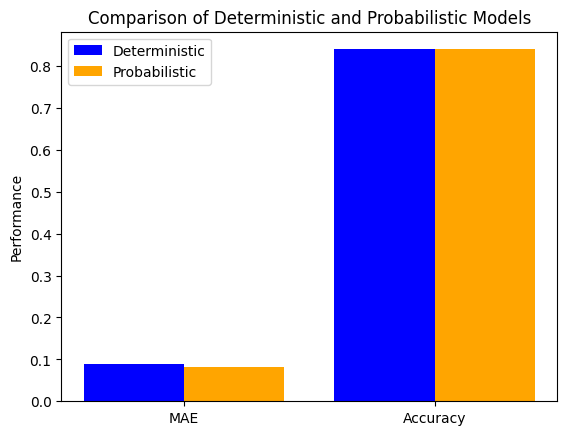

In [ ]:
def evaluate(model, dataloader, probabilistic=False):
    model.eval()
    mae_time = 0  # 时间预测的 MAE
    correct_events = 0  # 正确预测的事件数
    total_samples = 0  # 样本总数

    with torch.no_grad():
        for batch in dataloader:
            time_tensor, event_tensor = batch
            time_input, time_target = time_tensor[:, :-1], time_tensor[:, -1]
            event_input, event_target = event_tensor[:, :-1], event_tensor[:, -1]

            # 模型前向传播
            if probabilistic:
                time_mean, _, event_logits = model(time_input, event_input)
            else:
                time_mean, _, event_logits = model(time_input, event_input)

            # 时间预测 MAE
            mae_time += torch.abs(time_mean.view(-1) - time_target).sum().item()

            # 事件类型分类准确率
            event_pred = event_logits.argmax(dim=-1)
            correct_events += (event_pred == event_target).sum().item()
            total_samples += time_target.size(0)

    mae_time /= total_samples
    accuracy_event = correct_events / total_samples
    return mae_time, accuracy_event


# 数据预处理：验证集
x_times_valid_padded = pad_sequence(
    [torch.tensor(seq, dtype=torch.float32) for seq in dataset['validation']['time_since_last_event']],
    batch_first=True,
    padding_value=0.0
).to('cpu')

y_events_valid_padded = pad_sequence(
    [torch.tensor(seq, dtype=torch.long) for seq in dataset['validation']['type_event']],
    batch_first=True,
    padding_value=9
).to('cpu')

# 创建验证数据集和数据加载器
valid_dataset = TensorDataset(x_times_valid_padded, y_events_valid_padded)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# 确定性模型
deterministic_model = PointProcessNet(config=config, lossweight=[1.0]*config.event_class, probabilistic=False).to('cpu')
deterministic_model.set_optimizer(total_step=len(dataloader))

# 训练确定性模型
deterministic_model = PointProcessNet(config=config, lossweight=[1.0]*config.event_class, probabilistic=False).to('cpu')
deterministic_model.set_optimizer(total_step=len(dataloader))
for epoch in range(10):
    for batch in dataloader:
        loss1, loss2, loss = deterministic_model.train_batch(batch)
    print(f"Deterministic model training completed.")

# 训练概率模型
probabilistic_model = PointProcessNet(config=config, lossweight=[1.0]*config.event_class, probabilistic=True).to('cpu')
probabilistic_model.set_optimizer(total_step=len(dataloader))
for epoch in range(10):
    for batch in dataloader:
        loss1, loss2, loss = probabilistic_model.train_batch(batch)
    print(f"Probabilistic model training completed.")

# 验证确定性模型
det_mae, det_acc = evaluate(deterministic_model, valid_dataloader, probabilistic=False)
print(f"Deterministic Model - MAE: {det_mae:.4f}, Accuracy: {det_acc:.4f}")

# 概率模型
probabilistic_model = PointProcessNet(config=config, lossweight=[1.0]*config.event_class, probabilistic=True).to('cpu')
probabilistic_model.set_optimizer(total_step=len(dataloader))

# 概率模型训练
for epoch in range(10):
    total_loss = 0
    for batch in dataloader:
        loss1, loss2, loss = probabilistic_model.train_batch(batch)
        total_loss += loss
    avg_loss = total_loss / len(dataloader)
    print(f"[Probabilistic Model] Epoch [{epoch+1}/5], Loss: {avg_loss:.4f}")

# 验证概率模型
prob_mae, prob_acc = evaluate(probabilistic_model, valid_dataloader, probabilistic=True)
print(f"Probabilistic Model - MAE: {prob_mae:.4f}, Accuracy: {prob_acc:.4f}")

print("Final Comparison:")
print(f"Deterministic Model - MAE: {det_mae:.4f}, Accuracy: {det_acc:.4f}")
print(f"Probabilistic Model - MAE: {prob_mae:.4f}, Accuracy: {prob_acc:.4f}")


import matplotlib.pyplot as plt

# 数据准备
metrics = ['MAE', 'Accuracy']
det_results = [det_mae, det_acc]
prob_results = [prob_mae, prob_acc]

# 绘制柱状图
x = range(len(metrics))
plt.bar(x, det_results, width=0.4, label='Deterministic', color='blue')
plt.bar([p + 0.4 for p in x], prob_results, width=0.4, label='Probabilistic', color='orange')

# 添加标签
plt.xticks([p + 0.2 for p in x], metrics)
plt.ylabel('Performance')
plt.title('Comparison of Deterministic and Probabilistic Models')
plt.legend()
plt.show()


